### Compare similarities and influences between and within genres. What distinguishes a genre and how do genres change over time? Are some genres related to others?

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import ast
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [2]:
# load data into DFs
artists = pd.read_csv('data_by_artist.csv')
years = pd.read_csv('data_by_year.csv')
influence = pd.read_csv('influence_data.csv')

In [3]:
#remove songs by artists that arent in the artists table
#duplicate songs w/ more than one artist
#takes my computer about a minute to run
#can ignore the warnings about setting a copy of a slice from a dataframe
full = pd.read_csv('full_music_data.csv')
allArtists = list(artists['artist_id'])
newdict = {}

full['artists_id'] = [int(x.split(',')[0][1:-1]) if len(x.split(',')) == 1 else [int(y) for y in x[1:-1].split(',')] for x in list(full['artists_id'])]
full['artist_names'] = [ast.literal_eval(x) if len(ast.literal_eval(x)) > 1 else ast.literal_eval(x)[0] for x in full['artist_names']]
floor = min(full['tempo'])
span = max(full['tempo']) - floor
full['tempo'] = [(x-floor)/span for x in full['tempo']]

last_id = 0
row = 0
for i in range(len(full)): 
    thisRow = full.iloc[i,:]
    artIDs = thisRow['artists_id']
    artNames = thisRow['artist_names']
    
    if type(artIDs) == int:
        if artIDs == last_id: 
            thisRow['artists_id'] = artIDs
            thisRow['artist_names'] = artNames
            newdict[row] = thisRow.to_dict()
            row+=1
            last_id = artIDs
        else:
            if artIDs in allArtists:
                thisRow['artists_id'] = artIDs
                thisRow['artist_names'] = artNames
                newdict[row] = thisRow.to_dict()
                row+=1
                last_id = artIDs
                
    else:
        for j in range(len(artIDs)):
            artID = int(artIDs[j])
            artName = str(artNames[j])
            
            if artID in allArtists:
                thisRow['artists_id'] = artID
                thisRow['artist_names'] = artName
                newdict[row] = thisRow.to_dict()
                row+=1
    i+=1

full = pd.DataFrame.from_dict(newdict,'index')
full.head()

C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A

,artist_names,artists_id,danceability,energy,valence,tempo,loudness,mode,key,acousticness,instrumentalness,liveness,speechiness,explicit,duration_ms,popularity,year,release_date,song_title (censored)
0,Fat Freddy's Drop,178301,0.600,0.365,0.131,0.532777,-13.083,0,9,0.0672,0.585000,0.0921,0.0498,0,437200,54,2005,2005,Ernie
1,Fat Freddy's Drop,178301,0.874,0.326,0.179,0.490063,-13.302,0,11,0.0136,0.148000,0.0993,0.1310,0,581008,53,2005,2005,Wandering Eye
2,Fat Freddy's Drop,178301,0.670,0.531,0.336,0.571037,-8.267,0,9,0.0156,0.345000,0.3060,0.0377,0,431293,55,2009,8/7/2009,The Raft
3,Alexander O'Neal,625201,0.761,0.702,0.850,0.429237,-8.523,1,7,0.1080,0.000031,0.0935,0.0389,0,304427,34,1991,1/1/1991,All True Man
4,Alexander O'Neal,625201,0.661,0.828,0.902,0.471455,-12.673,0,11,0.2760,0.000001,0.2870,0.0390,0,264933,37,1987,7/29/1987,(What Can I Say) To Make You Love Me


In [4]:
# instantiate list of artist names and refine influence df

names = []
for i in artists['artist_name']:
    names.append(i)
influence = influence[influence['influencer_name'].isin(names)]
influence = influence[influence['follower_name'].isin(names)]
influence = influence.reset_index(drop=True)
influence

,influencer_id,influencer_name,influencer_main_genre,influencer_active_start,follower_id,follower_name,follower_main_genre,follower_active_start
0,759491,The Exploited,Pop/Rock,1980,74,Special Duties,Pop/Rock,1980
1,25462,Tricky,Electronic,1990,335,PJ Harvey,Pop/Rock,1990
2,66915,Bob Dylan,Pop/Rock,1960,335,PJ Harvey,Pop/Rock,1990
3,71209,Leonard Cohen,Pop/Rock,1950,335,PJ Harvey,Pop/Rock,1990
4,91438,The Gun Club,Pop/Rock,1980,335,PJ Harvey,Pop/Rock,1990
...,...,...,...,...,...,...,...,...
42747,580300,Sufjan Stevens,Pop/Rock,1990,3661738,Rosemary & Garlic,Pop/Rock,2010
42748,261309,Vybz Kartel,Reggae,2000,3670556,Trinidad Cardona,R&B;,2010
42749,467203,Michael Jackson,R&B;,1960,3670556,Trinidad Cardona,R&B;,2010
42750,2518003,Popcaan,Reggae,2000,3670556,Trinidad Cardona,R&B;,2010


In [5]:
# instantiate a list of each unique genre (there are 20)
genre = []
for i in influence['influencer_main_genre']:
    if i not in genre:
        genre.append(i)
for i in influence['follower_main_genre']:
    if i not in genre:
        genre.append(i)
genre

['Pop/Rock',
 'Electronic',
 'Reggae',
 'Jazz',
 'Country',
 'Comedy/Spoken',
 'R&B;',
 'Classical',
 'Latin',
 'Vocal',
 'Folk',
 'Easy Listening',
 'International',
 'Avant-Garde',
 'Blues',
 'Stage & Screen',
 'New Age',
 'Religious',
 "Children's",
 'Unknown']

In [6]:
# create dictionary with genre keys and lists of artists' names w/in that genre as values

artistByGenre = {}
for i in genre:
    artistByGenre[i] = []

i = 0
while i < len(influence):
    genreList = artistByGenre.get(influence['influencer_main_genre'][i])
    genreListF = artistByGenre.get(influence['follower_main_genre'][i])
    if influence['influencer_name'][i] not in genreList:
        genreList.append(influence['influencer_name'][i])
    if influence['follower_name'][i] not in genreListF:
        genreListF.append(influence['follower_name'][i])
    i += 1


In [7]:
# stats for jazz songs
jazzSongs = full[full['artist_names'].isin(artistByGenre.get('Jazz'))]
jazzSongs = jazzSongs.drop(['artist_names', 'artists_id', 'explicit', 'duration_ms', 'popularity', 'year', 'release_date', 'song_title (censored)'], axis=1)
jazzMeans = jazzSongs.mean(axis=0)
jazzMeans = jazzMeans.to_numpy()

In [8]:
# generalized - stats for songs in each genre
genreFeatures = []
for i in genre:
    songs = full[full['artist_names'].isin(artistByGenre.get(i))]
    songs = songs.drop(['artist_names', 'artists_id', 'explicit', 'duration_ms', 'popularity', 'year', 'release_date', 'song_title (censored)'], axis=1)
    means = songs.mean(axis=0)
    means = means.to_numpy()
    genreFeatures.append(means)

In [9]:
# similarity btwn jazz songs - cosine similarity
i = 0
jazzsim = []
while i < len(genre):
    sim = cosine_similarity(jazzMeans.reshape(1, -1), genreFeatures[i].reshape(1, -1))
    jazzsim.append(sim[0][0])
    i += 1

In [10]:
# instantiate DF of jazz's cosine similarity with other genres
d = {'Genre' : genre, 'Cosine Similarity' : jazzsim}
jazzSimilarity = pd.DataFrame(data=d)
jazzSimilarity = jazzSimilarity.sort_values(by=['Cosine Similarity'], ascending = False)
jazzSimilarity = jazzSimilarity.reset_index(drop=True)
jazzSimilarity.head()

,Genre,Cosine Similarity
0,Jazz,1.000000
1,Avant-Garde,0.999892
2,Easy Listening,0.999821
3,Folk,0.999606
4,Stage & Screen,0.998424


In [11]:
# not sure how this cell is different than the previous one
for i in genre:
    songs = full[full['artist_names'].isin(artistByGenre.get(i))]
    songs = songs.drop(['artist_names', 'artists_id', 'explicit', 'duration_ms', 'popularity', 'year', 'release_date', 'song_title (censored)'], axis=1)
    means = songs.mean(axis=0)

In [12]:
# create R&B genre df, sort by year, and reorder index
RBSongs = full[full['artist_names'].isin(artistByGenre.get('R&B;'))]
RBSongs = RBSongs.sort_values(by='year')
RBSongs = RBSongs.reset_index(drop=True)
RBSongs.head()

,artist_names,artists_id,danceability,energy,valence,tempo,loudness,mode,key,acousticness,instrumentalness,liveness,speechiness,explicit,duration_ms,popularity,year,release_date,song_title (censored)
0,Aretha Franklin,927555,0.496,0.829,0.733,0.487597,-8.876,0,5,0.629,0.076800,0.162,0.0519,0,161893,0,1927,1927,Evil **** ***** - Live
1,Screamin' Jay Hawkins,309458,0.845,0.455,0.896,0.356433,-13.668,0,5,0.710,0.420000,0.055,0.0488,0,145933,2,1927,1927,I Put A Spell On You - Live
2,Chuck Willis,126144,0.556,0.476,0.730,0.700698,-6.766,1,10,0.959,0.002400,0.242,0.0778,0,132733,0,1932,1932,Take It Like A Man (with The Royals)
3,Aretha Franklin,927555,0.648,0.356,0.529,0.355339,-13.917,0,7,0.896,0.000036,0.110,0.0837,0,186160,3,1936,1936,It Ain't Necessarily So - from ***** and Bess
4,Babyface,61226,0.400,0.408,0.143,0.567764,-8.039,0,0,0.771,0.013000,0.114,0.0286,0,287853,2,1941,1941,Strange Fruit


In [13]:
# genre roots -- influencers within a genre that have the most followers

# Avant-Garde roots (most common influencers)
AGRoots = influence[['influencer_name', 'follower_main_genre']]
AGRoots = AGRoots[AGRoots['follower_main_genre'] == 'Avant-Garde']
AGRoots = pd.DataFrame(AGRoots['influencer_name'].value_counts(ascending=False))
AGRoots = AGRoots.reset_index()
AGRoots = AGRoots.rename(columns={'index': 'Influencer', 'influencer_name': 'Number of AG Followers'})
AGRoots

,Influencer,Number of AG Followers
0,John Cage,6
1,Terry Riley,3
2,Moondog,2
3,Philip Glass,2
4,Brian Eno,2
5,Funkadelic,1
6,Talking Heads,1
7,Michael Nyman,1
8,Yngwie Malmsteen,1
9,Harold Budd,1


In [14]:
# Easy Listening roots (most common influencers)
ELroots = influence[['influencer_name', 'follower_main_genre']]
ELroots = ELroots[ELroots['follower_main_genre'] == 'Easy Listening']
ELroots = pd.DataFrame(ELroots['influencer_name'].value_counts(ascending=False))
ELroots = ELroots.reset_index()
ELroots = ELroots.rename(columns={'index': 'Influencer', 'influencer_name': 'Number of EL Followers'})
ELroots

,Influencer,Number of EL Followers
0,Les Baxter,4
1,Liberace,3
2,Martin Denny,3
3,Percy Faith,2
4,AntÃ´nio Carlos Jobim,2
5,George Shearing,2
6,Milt Jackson,1
7,Alanis Morissette,1
8,Paul Weston,1
9,Ray Conniff,1


In [15]:
# Jazz roots (most common influencer)
jazzRoots = influence[['influencer_name', 'follower_main_genre']]
jazzRoots = jazzRoots[jazzRoots['follower_main_genre'] == 'Jazz']
jazzRoots = pd.DataFrame(jazzRoots['influencer_name'].value_counts(ascending=False))
jazzRoots = jazzRoots.reset_index()
jazzRoots = jazzRoots.rename(columns={'index': 'Influencer', 'influencer_name': 'Number of Jazz Followers'})
jazzAGoverlap = jazzRoots[jazzRoots['Influencer'].isin(AGRoots['Influencer'])]
jazzELoverlap = jazzRoots[jazzRoots['Influencer'].isin(ELroots['Influencer'])]
jazzELoverlap

,Influencer,Number of Jazz Followers
0,Miles Davis,83
18,Erroll Garner,18
30,Stan Getz,13
80,George Shearing,7
106,Milt Jackson,5
110,AntÃ´nio Carlos Jobim,5
129,JoÃ£o Gilberto,4
154,The Beatles,4
185,Artie Shaw,3
187,Frank Sinatra,3


In [159]:
# jazz genre adherence -- how well the jazz genre retains its followers (i.e. they are also part of jazz)
adherence = influence[['influencer_name','influencer_main_genre', 'follower_name','follower_main_genre']]
adherence = adherence[adherence['influencer_main_genre'] == "Jazz"]

totalFollowersGenres = adherence['follower_main_genre'].value_counts().sum()

totalJazzFollowers = adherence[adherence['follower_main_genre'] == 'Jazz']['follower_main_genre'].value_counts().sum()


percentGenreAdherence = totalJazzFollowers/totalFollowersGenres *100
percentGenreAdherence

65.13254786450663

In [143]:
# jazz influencer adherence -- how much influence a jazz influencer has over keeping its followers in jazz
uniqueInfNames = list(set(adherence['influencer_name']))
infGenreAdherence = []

for i in uniqueInfNames:
    influencerSubset = adherence[adherence['influencer_name'] == i]
    totalInfluencerFollowers = influencerSubset['follower_main_genre'].value_counts().sum()

    totalInfluencerJazzFollowers = influencerSubset[influencerSubset['follower_main_genre'] == 'Jazz']['follower_main_genre'].value_counts().sum()

    
    percentInfGenreAdherence = totalInfluencerJazzFollowers / totalInfluencerFollowers * 100
    infGenreAdherence.append(percentInfGenreAdherence)

In [151]:
# instantiate jazz influencer adherence df
jazzInfluencerAdherence = pd.DataFrame(data= {'influencer_name': uniqueInfNames, 'genre_adherence': infGenreAdherence })
jazzInfluencerAdherence.head()

,influencer_name,genre_adherence
0,Bola Sete,0.000000
1,Philly Joe Jones,81.818182
2,Cal Tjader,66.666667
3,BÃ©la Fleck,0.000000
4,Jean-Luc Ponty,66.666667


In [61]:
# generalized adherence percentages for all genres -- how well a genre retains its followers (i.e. they are also part of same genre)

genreAdherence = []
for i in genre:
    allAdherence = influence[['influencer_name','influencer_main_genre', 'follower_name','follower_main_genre']]
    allAdherence = allAdherence[allAdherence['influencer_main_genre'] == i]
    
    totalFollowers = allAdherence['follower_main_genre'].value_counts().sum()

    totalSameGenreFollowers = allAdherence[allAdherence['follower_main_genre'] == i]['follower_main_genre'].value_counts().sum()


    percentGenreAdherence = totalSameGenreFollowers / totalFollowers *100
    genreAdherence.append(percentGenreAdherence)

# instantiate df for all genre adherence data
allGenreAdherences = pd.DataFrame(data= {'genre': genre, 'adherence %': genreAdherence} )    

In [186]:
allGenreAdherences

,genre,adherence %
0,Pop/Rock,91.327778
1,Electronic,52.394366
2,Reggae,72.456576
3,Jazz,65.132548
4,Country,75.795214
5,Comedy/Spoken,66.447368
6,R&B;,61.193490
7,Classical,14.912281
8,Latin,65.217391
9,Vocal,37.977369


In [37]:
# generalized adherence percentages for influencers -- how much influence an artist has over keeping its followers in the same genre

allUniqueInfNames = list(set(influence['influencer_name']))
allCorrespInfGenres = []
allInfAdherence = []

for i in allUniqueInfNames:
    influencerSubset = influence[influence['influencer_name'] == i]
    totalInfluencerFollowers = influencerSubset['follower_main_genre'].value_counts().sum()

    influencerGenre = str(set(influencerSubset['influencer_main_genre']).pop())
    allCorrespInfGenres.append(influencerGenre)
    
    totalSameGenreFollowers = influencerSubset[influencerSubset['follower_main_genre'] == influencerGenre]['follower_main_genre'].value_counts().sum()

    percentInfAdherence = totalSameGenreFollowers / totalInfluencerFollowers * 100
    allInfAdherence.append(percentInfAdherence)


In [38]:
# instantiate df for influencer adherence values
allInfluencerAdherences = pd.DataFrame(data = {'influencer_name': allUniqueInfNames, 'influencer_genre': allCorrespInfGenres, 'adherence %': allInfAdherence})

In [39]:
allInfluencerAdherences

,influencer_name,influencer_genre,adherence %
0,Michael Nyman,Stage & Screen,0.000000
1,Conway Twitty,Country,83.333333
2,Billie Holiday,Vocal,32.075472
3,Caravan,Pop/Rock,100.000000
4,Red Mitchell,Jazz,100.000000
...,...,...,...
3756,Neko Case,Pop/Rock,100.000000
3757,X,Pop/Rock,100.000000
3758,Ali Farka TourÃ©,International,80.000000
3759,Redd Kross,Pop/Rock,100.000000


In [246]:
# summary stats
allInfluencerAdherences.min()

influencer_name     'Til Tuesday
influencer_genre     Avant-Garde
adherence %                    0
dtype: object

In [247]:
# summary stats
allInfluencerAdherences.max()

influencer_name     Ã‰dith Piaf
influencer_genre          Vocal
adherence %                 100
dtype: object

In [248]:
# summary stats
allInfluencerAdherences.describe()

,adherence %
count,3761.000000
mean,76.084950
std,33.350838
min,0.000000
25%,57.142857
50%,100.000000
75%,100.000000
max,100.000000


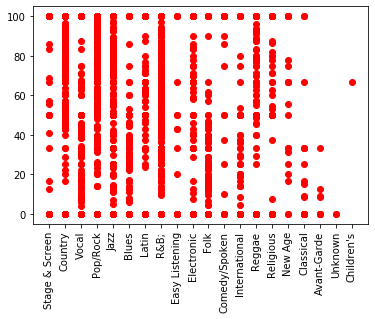

In [68]:
# visual of influencer adherence
genre = allInfluencerAdherences['influencer_genre']
adherence_per = allInfluencerAdherences['adherence %']
plt.plot(genre, adherence_per, 'ro')
plt.xlim(-1, 20)
plt.tick_params(axis ='x', rotation = 50)

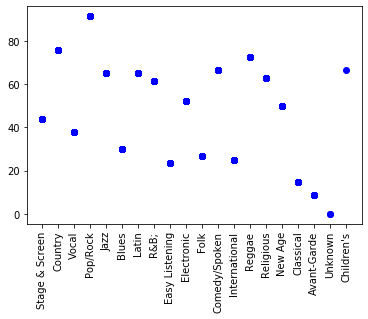

In [66]:
# visual of genre adherence
genre = allGenreAdherences['genre']
adherence_per = allGenreAdherences['adherence %']
plt.plot(genre, adherence_per, 'bo')
plt.tick_params(axis ='x', rotation = 90)

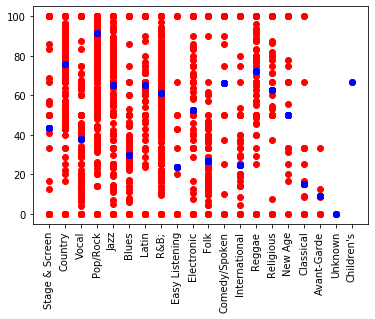

In [69]:
# visual of adherences - genre overall in blue, indiv influencers in red to show spread

# note: children's and unknown genres only have one influencer so red and blue points are the same
# note: interesting that each genre has at least one influencer with 100% adherence and at least one with 0% adherence

genre = allInfluencerAdherences['influencer_genre']
adherence_per = allInfluencerAdherences['adherence %']
plt.plot(genre, adherence_per, 'ro')
plt.xlim(-1, 20)
plt.tick_params(axis ='x', rotation = 90)

genre = allGenreAdherences['genre']
adherence_per = allGenreAdherences['adherence %']
plt.plot(genre, adherence_per, 'bo')
plt.tick_params(axis ='x', rotation = 90)